In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
import json
import torch
import yaml
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from nerfstudio.engine.trainer import Trainer
from nerfstudio.utils.eval_utils import eval_setup

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
os.chdir('/workspace')
#Path params
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/workspace/outputs/jackal_four_spins/plane-nerf/2024-01-08_002218"
DATA_PATH = "/stored_data/jackal_four_spins"
INPUT_FRAME = 0
TARGET_FRAME = 6
#Model params
L_RATE = 1e-2
N_STEP = 500

TRANSFORM_PATH = os.path.join(DATA_PATH, "transforms.json")
with open(TRANSFORM_PATH) as f:
    TRANSFORM_JSON = json.load(f)

WIDTH = TRANSFORM_JSON["w"]
HEIGHT = TRANSFORM_JSON["h"]

print(TRANSFORM_JSON)
INPUT_PATH = {
    "tf" : TRANSFORM_JSON["frames"][INPUT_FRAME]["transform_matrix"],
    "images" : os.path.join(DATA_PATH, "images", f"{INPUT_FRAME}.png"),
    "masks" : os.path.join(DATA_PATH, "masks", f"{INPUT_FRAME}.png")
}
TARGET_PATH = {
    "tf" : TRANSFORM_JSON["frames"][TARGET_FRAME]["transform_matrix"],
    "images" : os.path.join(DATA_PATH, "images", f"{TARGET_FRAME}.png"),
    "masks" : os.path.join(DATA_PATH, "masks", f"{TARGET_FRAME}.png")
}

{'focal_length': 50.0, 'fov_x': 0.85172, 'w': 1640, 'h': 1232, 'pixel_width': 0.06965178305458342, 'pixel_height': 0.06965178305458342, 'fl_x': 717.8567124522416, 'fl_y': 717.8567124522416, 'cx': 820, 'cy': 616, 'camera_model': 'OPENCV', 'frames': [{'file_path': 'images/0.png', 'transform_matrix': [[1.0, 0.0, 0.0, 0.0], [0.0, 0.7648421872844884, -0.644217687237691, -1.5], [0.0, 0.644217687237691, 0.7648421872844884, 1.0], [0.0, 0.0, 0.0, 1.0]], 'mask_path': 'masks/0.png'}, {'file_path': 'images/1.png', 'transform_matrix': [[0.9921147013144778, -0.0958601444987601, 0.08074188586081742, 0.18799985034645633], [0.12533323356430423, 0.7588111781904621, -0.6391378383553254, -1.4881720519717168], [0.0, 0.644217687237691, 0.7648421872844884, 1.0], [0.0, 0.0, 0.0, 1.0]], 'mask_path': 'masks/1.png'}, {'file_path': 'images/2.png', 'transform_matrix': [[0.9685831611286312, -0.19020851725470017, 0.1602104239487451, 0.3730348307472822], [0.24868988716485482, 0.7408132635245464, -0.6239784039596586, 

In [4]:
def get_image_to_tensor_balanced(image_size=0):
    ops = []
    if image_size > 0:
        ops.append(transforms.Resize(image_size))
    ops.extend(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
    )
    return transforms.Compose(ops)

(1232, 1640, 3)


Text(0.5, 1.0, 'Target image')

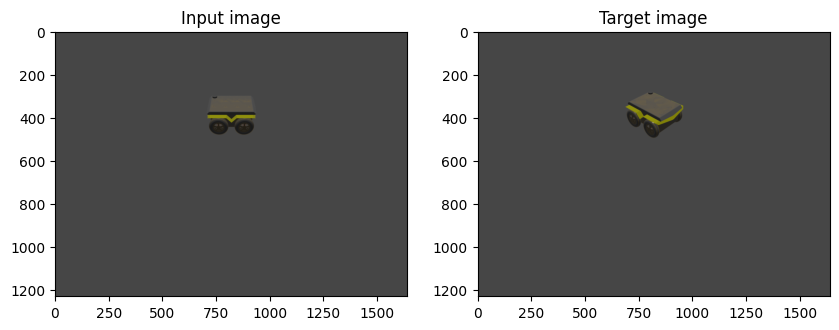

In [5]:
input_image_np = np.array(Image.open(INPUT_PATH["images"]).resize((WIDTH,HEIGHT)).convert("RGB"))
target_image_np = np.array(Image.open(TARGET_PATH["images"]).resize((WIDTH,HEIGHT)).convert("RGB"))
print(input_image_np.shape)

#Plot with matplotlib
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(input_image_np)
ax.set_title("Input image")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(target_image_np)
ax.set_title("Target image")

In [6]:
config_path = os.path.join(MODEL_PATH, "config.yml")

config = yaml.load(Path(config_path).read_text(), Loader=yaml.Loader)

config, pipeline, checkpoint_path, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

WARNING: Using slower TCNN CutlassMLP instead of TCNN FullyFusedMLP

Use layer width of 16, 32, 64, or 128 to use the faster TCNN FullyFusedMLP.

WARNING: Using slower TCNN CutlassMLP instead of TCNN FullyFusedMLP

Use layer width of 16, 32, 64, or 128 to use the faster TCNN FullyFusedMLP.

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_four_spins/plane-nerf/2024-01-08_002218/nerfstudio_models/step-000009999.ckpt

In [8]:
image_to_tensor = get_image_to_tensor_balanced()

# Encoding the input image.
print(f"Input image: {INPUT_PATH['images']}")
input_image = Image.fromarray(input_image_np)
input_image = image_to_tensor(input_image).to(device=DEVICE)
input_pose = torch.eye(4)

print(f"Target image: {TARGET_PATH['images']}")
target_image = Image.fromarray(target_image_np)
target_image_flatten = np.reshape(target_image, [-1, 3]) / 255.0
target_image_flatten = torch.from_numpy(target_image_flatten).float().to(device=DEVICE)

cam_pose = torch.clone(input_pose.detach()).unsqueeze(0)
cam_pose.requires_grad = True

print("Input pose:")
print(f"{input_pose}")
print("Init pose:")
print(f"{cam_pose[0]}")


Input image: /stored_data/jackal_four_spins/images/0.png
Target image: /stored_data/jackal_four_spins/images/6.png
Input pose:
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
Init pose:
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], grad_fn=<SelectBackward0>)


In [7]:

# Create optimizer.
optimizer = torch.optim.Adam(params=[cam_pose], lr=L_RATE)
n_steps = 100 + 1

# Loss.
mse_loss = torch.nn.MSELoss()

# Sampling.
n_rays = 1024
sampling = 'center'

# Pose optimization.
predicted_poses = []
fine_patches = []
gt_patches = []

for i_step in range(N_STEP):
    # Encode.
    net.encode(
        input_image.unsqueeze(0), input_pose.unsqueeze(0).to(device=device), focal,
    )

    render_rays = util.gen_rays(cam_pose, W, H, focal, z_near, z_far)
    render_rays_flatten = render_rays.view(-1, 8)
    assert render_rays_flatten.shape[0] == H*W
    if sampling == 'random':
        idxs_sampled = torch.randint(0, H*W, (n_rays,))
    elif sampling == 'center':
        frac = 0.5
        mask = torch.zeros((H, W))
        h_low = int(0.5*(1-frac)*H)
        h_high = int(0.5*(1+frac)*H)
        w_low = int(0.5*(1-frac)*W)
        w_high = int(0.5*(1+frac)*W)
        mask[h_low:h_high, w_low:w_high] = 1
        mask = mask.reshape(H*W)

        idxs_masked = torch.where(mask>0)[0]
        idxs_sampled = idxs_masked[torch.randint(0, idxs_masked.shape[0], (n_rays,))]
    elif sampling == 'patch':
        frac = 0.25
        mask = torch.zeros((H, W))
        h_low = int(0.5*(1-frac)*H)
        h_high = int(0.5*(1+frac)*H)
        w_low = int(0.5*(1-frac)*W)
        w_high = int(0.5*(1+frac)*W)
        mask[h_low:h_high, w_low:w_high] = 1
        mask = mask.reshape(H*W)

        idxs_sampled = torch.where(mask>0)[0]

    render_rays_sampled = render_rays_flatten[idxs_sampled].to(device=DEVICE)

    rgb, _ = render_par(render_rays_sampled[None])
    loss = mse_loss(rgb, target_image_flatten[idxs_sampled][None])

    optimizer.zero_grad()
    loss.backward()

    if i_step % 10 == 0:        
        predicted_poses.append(torch.clone(cam_pose[0]).detach().numpy())
        fine_patches.append(torch.clone(rgb[0]).detach().cpu().numpy().reshape(32, 32, 3))
        gt_patches.append(torch.clone(target_image_flatten[idxs_sampled]).detach().cpu().numpy().reshape(32, 32, 3))

#         pose_pred = predicted_poses[-1].copy()
#         pose_pred[2, -1] -= args.radius
#         pose_pred = pose_input @ pose_pred
#         error_R, error_t = compute_pose_error(pose_pred, pose_target)
        print(f"Step {i_step}, loss: {loss}")
        
    optimizer.step()
    
    break


Input image: /stored_data/jackal_four_spins/images/0.png
Target image: /stored_data/jackal_four_spins/images/6.png
Input pose:
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
Init pose:
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], grad_fn=<SelectBackward0>)


NameError: name 'net' is not defined